In [1]:
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import time
import geopandas as gpd
import os; os.chdir('../..')

In [2]:
from utils import cleaning_stations
from utils import assign_strata

In [3]:
path_data = '/Users/juandavidcaicedocastro/TM_datos/01_clean/'
path_results = '/Users/juandavidcaicedocastro/Documents/BERKELEY/17_PhD/08_Results/helper_tables/'

# Exploratory data analysis

## Number of transactions per user 

In [5]:
dat = pd.read_csv('/Users/juandavidcaicedocastro/Documents/BERKELEY/17_PhD/02_Data/03_Transmilenio/02_255 project/data/id_frequency.csv')
print( 'Smartcard universe: ', dat.shape[0])

Smartcard universe:  15360405


In [ ]:
dat[dat['count'] > 10]

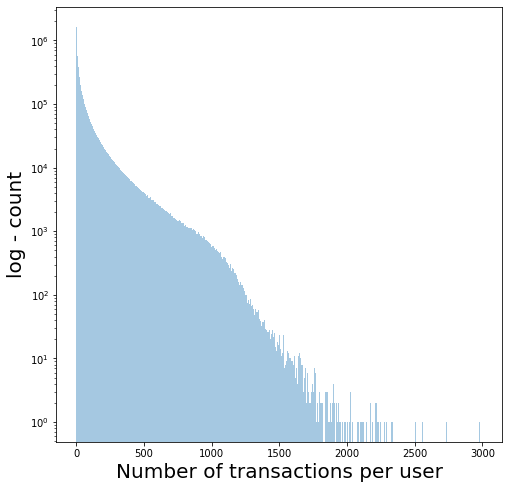

In [19]:
# dat = pd.read_csv(os.getcwd() + '/data/id_frequency.csv')
fig, ax = plt.subplots(figsize = (8,8))
sns.distplot(dat['count'], ax = ax, kde= False, bins = range(1,3000, 2))
ax.set_ylabel('log - count', fontsize = 20)
ax.set_xlabel('Number of transactions per user', fontsize = 20)
# ax.set_title('Distribution of the number of transactions per user', fontsize = 20)
ax.set_yscale('log')
# ax.axvline(x=10, color = 'orange');

The distribution of number of transactions per user has a negative exponential shape. This means that the mayority of the unique card ids uses the BRT system exporadically. Taking into account that the system has about ~2.4 M transactions per day, one could estimate that about 13 million transactions in the time period where sporadic, and for which no pattern may be recongnize. However, the number of consistent users have more observations in the data timeline and is posible to recognize a pattern. 


I recognize that I should find a way to filter out users with no pattern, but for now I will include all users in the analysis, regardless of how many transactions the user has. This filter needs to be carefully planned and It'll be done in future analysys. 

# Data

- Transactions: raw transactions in the timeperiod where data is available for 50.000 unique card IDs. 
- Stations: raw BRT stations 
- blocks: block shape file with strata as attribute
- GTFS bogota: http://transitfeeds.com/p/simur-bogota/973

Note: Transactions has information of 50.000 random users from the universe (~15.36 M). 

In [ ]:
# ids = pd.read_csv(path_results + 'final_ids.csv').idnumerotarjeta
# df = load_data(path_data + '0_users.csv', id_filter = ids)

In [ ]:
def load_data(filename, id_filter = None):
    
    df = pd.read_csv(filename).iloc[:,1:]
    if id_filter is not None:
        df = df[df.idnumerotarjeta.isin(id_filter)]
    return df

In [ ]:
def find_rank(df):  
    df.datetime = pd.to_datetime(df.datetime)
    df['time'] = df.datetime.dt.hour + df.datetime.dt.minute/60 + df.datetime.dt.second/3600
    df = df.groupby(['idnumerotarjeta', 'recaudoestacion']).agg({'valor': 'count', 'time': 'mean'})
    df['rank_value'] = df.groupby('idnumerotarjeta')['valor'].\
                rank(ascending = False, method = 'first')
    return df.reset_index()

In [ ]:
def find_HW(df):
    ''' Input:
    - 
    Output: rank-1 and rank-2 stations per user
    '''
    df = df[df.rank_value.isin([1,2])]
    df = df.pivot(index = 'idnumerotarjeta', 
                  columns = 'rank_value')[['recaudoestacion', 'time']]
    return df

In [ ]:
not_include = np.array(['.DS_Store'])
files = np.array(os.listdir(path_data))
files = files[~np.isin(files,not_include)]

In [ ]:
tables_list = []
ids = pd.read_csv(path_results + 'final_ids.csv').idnumerotarjeta
for file in files:
    try:
        start_time = time.time()
        print(file)
        df = load_data(path_data + file, id_filter = ids)
        df_ranked = find_rank(df)
        df_HW = find_HW(df_ranked)
        tables_list.append(df_HW)
        duration = time.time() - start_time
        print('Calculation took {:.3f} seconds to run.'.format(duration))
    except (KeyError, ValueError):
        pass

In [ ]:
results = pd.concat(tuple(tables_list), axis = 0)
results.shape

In [ ]:
results.to_csv(path_results + 'HW_stations_users.csv')

## Infering home and work location 

To infere home and work location, we will use a simple algorithm which will rank the most visited stations, where rank want is the most visited station for user n. The logic behind the logic is that, in general, most of the trips origin from home and finish at home, and so we will assing rank-1 stations as home-station. Then, rank-2 (the second most visited station) will be assume a mandatory activity (work/shcool). Other ranks will be assume to be other locations for other purpuses. 

In this section I will try to validate that my assumption are valid to a certain extend. 

Validatation: 
- Distribution of home and work/study locations should be consistent with the land use of Bogota. 
- Home stations trips will peak in the morning 
- Work stations trips will peak in the afternoon

In [58]:
stations = pd.read_csv(path_results + 'stations_w_strata')
results = pd.read_csv(path_results + 'HW_stations_users.csv', )
results.columns = ['idnumerotarjeta', 'rank1', 'rank2', 'rank1_time', 'rank2_time']
results = results.loc[2:,:]

In [59]:
HW = results.merge(stations[['recaudoestacion','ESTRATO', 'latitud', 'longitud']], 
                                 how = 'left', left_on = 'rank1', right_on = 'recaudoestacion')

In [60]:
HW = HW.merge(stations[['recaudoestacion','latitud', 'longitud']], 
                                 how = 'left', left_on = 'rank2', right_on = 'recaudoestacion')

In [61]:
replace_dict = {'latitud_x':'home_lat', 'longitud_x':'home_lon', 
                'latitud_y':'work_lat', 'longitud_y':'work_lon',
                'recaudoestacion_x':'home', 'recaudoestacion_y':'work' }

HW.rename(columns=replace_dict, inplace = True)

In [142]:
# Localidades shapefiles
lsoas_link = os.getcwd() + '/02_Data/03_Transmilenio/02_255 project/data/localidades_shp/Loca.shp'
lsoas = gpd.read_file(lsoas_link)
lsoas.drop(index = 8, inplace= True )
lsoas['bogota']= 1
bogota = lsoas.dissolve(by = 'bogota')
bogota['LocNombre'] = 'Bogotá'

#Troncales shapefiles
troncal_shape = os.getcwd() + '/02_Data/03_Transmilenio/02_255 project/data/troncal_shape/corredores-troncal-tm.shp'
troncal = gpd.read_file(troncal_shape)
troncal['troncal'] = 'Transmilenio corridors'

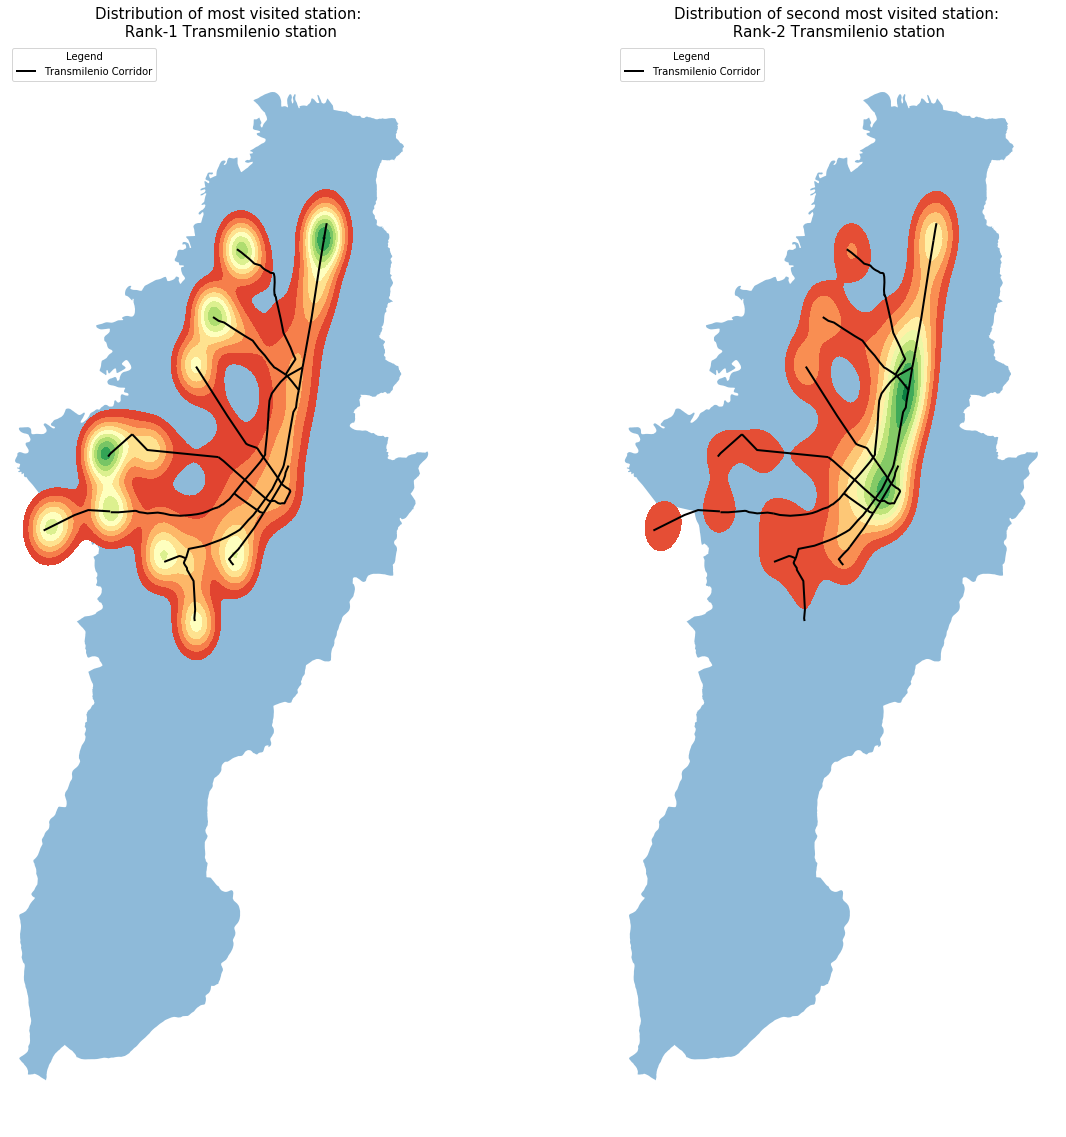

In [141]:
to_plot = HW.sample(10000) # Just faster performance 

#Plotting distributions rank 1, rank2 and rank 3 stations. 
f, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20, 20),)

# bogota.plot(alpha=0.5, linewidth=1, column = 'LocNombre', legend = True )
bogota.plot(alpha=0.5, linewidth=1, axes = axes[0],column = 'LocNombre', legend = True, label = 'Bogota')
sns.kdeplot(to_plot.home_lon, to_plot.home_lat,shade = True, 
            shade_lowest=False, cmap = 'RdYlGn', ax = axes[0])
troncal.plot(alpha=1, color= 'Black', axes = axes[0], 
             label = 'Transmilenio Corridor', linewidth = 2)

axes[0].set_axis_off()
axes[0].set_title("Distribution of most visited station:\n Rank-1 Transmilenio station",
                      fontsize = 15)
axes[0].legend(title="Legend", loc = 'upper left' )


to_plot = HW.sample(2000)
bogota.plot(alpha=0.5, linewidth=1, axes = axes[1], column = 'LocNombre', legend = True )
sns.kdeplot(to_plot.work_lon, to_plot.work_lat, shade = True, 
            shade_lowest=False, cmap = 'RdYlGn', ax = axes[1])
troncal.plot(alpha=1, color= 'Black', axes = axes[1], 
             label = 'Transmilenio Corridor', linewidth = 2)
axes[1].set_axis_off()
axes[1].set_title("Distribution of second most visited station:\n Rank-2 Transmilenio station",
                      fontsize = 15)
axes[1].legend(title="Legend", loc = 'upper left' );

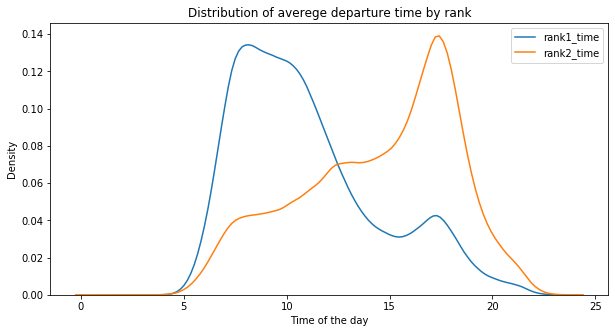

In [116]:
fig, ax = plt.subplots(figsize = (10,5))
sns.kdeplot(HW.rank1_time, legend = True)
sns.kdeplot(HW.rank2_time, legend = True)
plt.title('Distribution of averege departure time by rank')
plt.ylabel('Density')
plt.xlabel('Time of the day');

As seen in these plots, rank-1 is heavily distributed in the outskirts of Bogota, where most of the low-inocme residential zones are. In rank-2 stations, the distribution is more concentrated in the down-town area, where most of the jobs are located. Interestingly, rank-3 stations are also located in the the down-town area, where most of the restaurant, venues and discretionary activities would be located as well. In general, the distribution of rank-1 and rank-2 stations conicides with the land-use of Bogota. While we acknwoldge that the inputation is not perfect, the rank-algorithm seems to represent the reallity of home and work/school location at the BRT level. 

## Rank 1 by strata

Now, as we assign a strata to each station, the we assing a strata on each user based on the home-station. The logic behind this is that the imputed home station is the closest to their home, and so, the average strata around that station is assign to that user. 

We compare it the distribution of users by statra with the general population by strata to answer what strata ("proxy for income") use public transportation in Bogota. 

In [150]:
users_strata = HW.ESTRATO.replace(0,1).value_counts().sort_index()
frac_users_strata = users_strata/users_strata.sum()

# Fraction of the population by strata
# Hardcoded because i couldn't find an easfile to process this in the census data. 
estrato_bogota = pd.Series([0.0915,0.4137,0.3552,0.0942,0.0299,0.0155], index = [1,2,3,4,5,6])

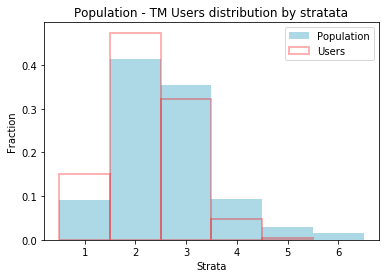

In [147]:
p1 = plt.bar(estrato_bogota.index, estrato_bogota, width = 1, color = 'lightblue')
p2 = plt.bar(frac_users_strata.index, frac_users_strata, 
             width = 1, edgecolor = 'red', linewidth = 2, 
             fill=False, alpha = 0.3)
plt.legend((p1[0], p2[0]), ('Population', 'Users'))
plt.ylabel('Fraction')
plt.xlabel('Strata')
plt.title('Population - TM Users distribution by stratata');

It seems that the proportion of the population by strata has a similar distribution of the users by strata. For strata 1 and 2, the proportion of users is greater than the proportion of the population, which indicates that transit is one of the few alternatives of transportation for those users. In highe stratas, the opposite is true. 

## Distributions of start time by strata

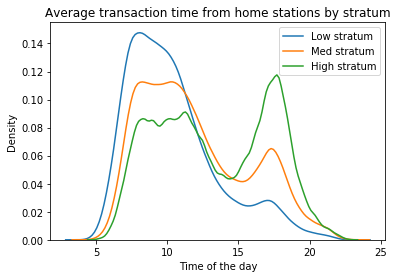

In [162]:
sns.kdeplot(HW[HW.ESTRATO.isin([1,2])].rank1_time, bw=.2, label="Low stratum")
sns.kdeplot(HW[HW.ESTRATO.isin([3,4])].rank1_time, bw=.2, label="Med stratum")
sns.kdeplot(HW[HW.ESTRATO.isin([5,6])].rank1_time, bw=.2, label="High stratum");

plt.title('Average transaction time from home stations by stratum')
plt.xlabel('Time of the day')
plt.ylabel('Density');

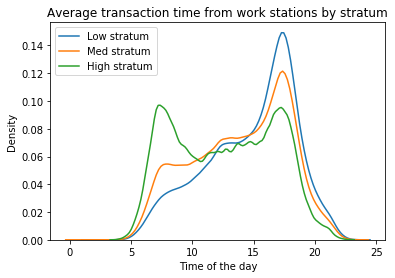

In [163]:
sns.kdeplot(HW[HW.ESTRATO.isin([1,2])].rank2_time, bw=.2, label="Low stratum")
sns.kdeplot(HW[HW.ESTRATO.isin([3,4])].rank2_time, bw=.2, label="Med stratum")
sns.kdeplot(HW[HW.ESTRATO.isin([5,6])].rank2_time, bw=.2, label="High stratum");

plt.title('Average transaction time from work stations by stratum')
plt.xlabel('Time of the day')
plt.ylabel('Density');

In the last 2 graphs, we plotted the departure time for home stations and work/school stations. As expected, departures from the home location tend peak in the morning, as users are trying to access to their mandatory activity (work/shcool). It is interesting, howerver, that for high income, the distribution is more bimodal, with peaks in the morning and the afternoon. This could be explain because high-income users may have access to more discretionary activities. 

Work departure times peak in the afternoon, which is consistent with the end of the workday. In this case, rank-2 for low and middle income people follows a distribution that peaks in the morning. While for high income users, the distribution is also bimodal. 

The high income distributions needs to be revisited. One option to improve the home/work station algortihm would be to estimate the rank by time of the day. This means, estimate rank-1 stations in the morning, for home location, and rank-1 station in the afternoon for work location. This would assume that there is no user that works at night/afternoon and returns home in the morning. 